# Xue & Leibler, PNAS 2016

At each generation:

1. individuals develop a phenotype according to their phenotype distribution $\pi$: $\pi_i \in [0,1]$ is the probability that a specific individual will develop to phenotype $\phi_i$.
1. the fitness of individuals is set according to their phenotype and the environment $\epsilon \in {0, 1}$.
. individuals reproduce: the relative contribution (fitness) of individuals with phenotype $\phi_i$ in environment $\epsilon_j$ to the next generation is $\frac{\omega_i^{(j)}}{\sum_k{\phi_k^j}}$.
1. each offspring phenotype distribution is inherited from its parent, where a fraction $1-\eta$ is determined according to the parent phenotype distribution and a fraction $\eta$ is determined according to the parent phenotype; the offspring distribution is $\pi_i' = (1-\eta)\phi_i + \eta * \delta_{i,k}$, where $k$ is the parent phenotype.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style='ticks', context='paper', font_scale=1.3)
from simulation import *

# Figure 2

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey='row')

N=100000
n=100
η=0.1
ω0=2
ω1=0.2
π0=0.5
p0 = 0.5

## Fig. 2A
ϵ = np.random.choice(2, n, True, [0.7, 0.3])
π = simulation(N, n, η, ω0, ω1, π0, ϵ)
plot_π(π, ϵ, ax=ax[0, 0])
plot_logNtN0(π, ω0, ω1, 0.7, ϵ, ax=ax[1,0])

## Fig. 2B
ϵ, a = np.zeros(n, dtype=int), 0
while a < ϵ.size:
    a += np.random.geometric(1/10)
    g = np.random.geometric(1/5)
    ϵ[a: a + g] = 1
    a += g
π = simulation(N, n, η, ω0, ω1, π0, ϵ)
plot_π(π, ϵ, ax=ax[0,1])
plot_logNtN0(π, ω0, ω1, 0.7, ϵ, ax=ax[1,1])

## Fig. 2C
ϵ = np.array([0] * 40 + [1] * 40 + [0] * 20)
π = simulation(N, n, η, ω0, ω1, π0, ϵ)
plot_π(π, ϵ, ax=ax[0,2])
plot_logNtN0(π, ω0, ω1, 0.7, ϵ, ax=ax[1,2]);

# Modifier competitions in Fig. 2

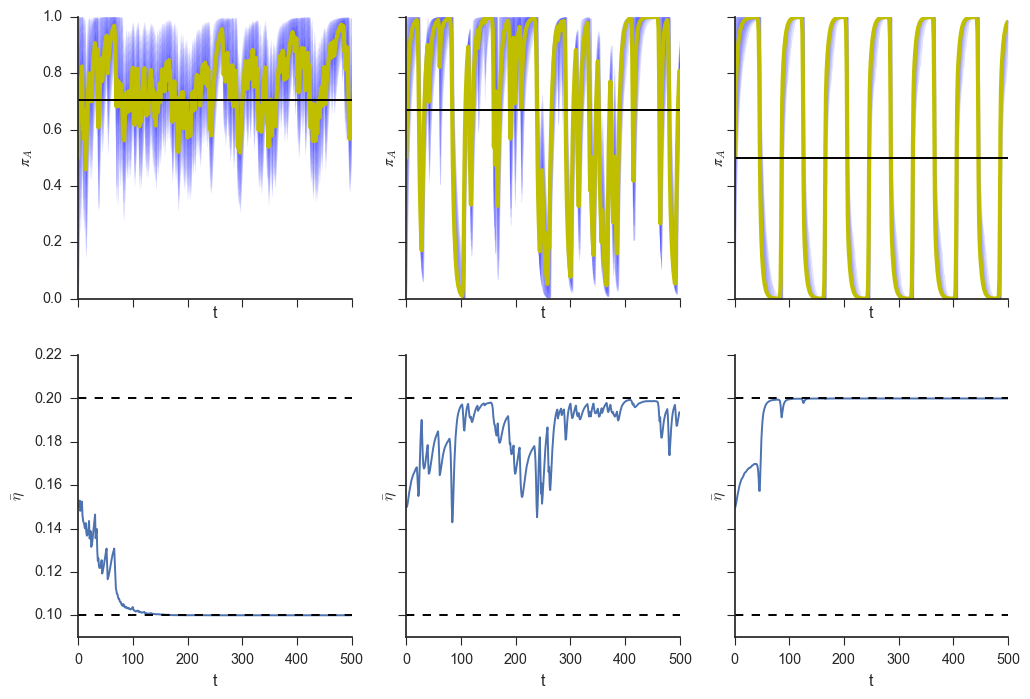

In [107]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey='row')

N=100000
n=500
η1=0.1
η2=0.2
ω0=2
ω1=0.2
π0=0.5
p0 = 0.5

## Fig. 2A
ϵ = np.random.choice(2, n, True, [0.7, 0.3])
π, η_bar = simulation(N, n, η1, η2, ω0, ω1, π0, ϵ)
plot_π(π, ϵ, ax=ax[0, 0])
plot_η(η_bar, η1, η2, ax=ax[1, 0])

## Fig. 2B
ϵ, a = np.zeros(n, dtype=int), 0
while a < ϵ.size:
    a += np.random.geometric(1/10)
    g = np.random.geometric(1/5)
    ϵ[a: a + g] = 1
    a += g
π, η_bar = simulation(N, n, η1, η2, ω0, ω1, π0, ϵ)
plot_π(π, ϵ, ax=ax[0, 1])
plot_η(η_bar, η1, η2, ax=ax[1, 1])

## Fig. 2C
ϵ = np.array(([0] * 40 + [1] * 40) * (n//40 + 1))
π, η_bar = simulation(N, n, η1, η2, ω0, ω1, π0, ϵ)
plot_π(π, ϵ, ax=ax[0, 2])
plot_η(η_bar, η1, η2, ax=ax[1, 2])